In [1]:
!pip install torch torchvision scikit-learn matplotlib seaborn SimpleITK -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [2]:
# LUNA16 Pulmonary Nodule Detection - Full Pipeline (Transformer)

# ======================================================
# 📚 1. Install and Import Libraries
# ======================================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tqdm import tqdm




In [13]:
import pandas as pd

annotations = pd.read_csv("/kaggle/input/luna-lung-cancer-dataset/annotations.csv")  # update path if needed
print(annotations.columns)


Index(['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm'], dtype='object')


                                           seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 -286.62   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -33.66  -72.75 -308.41   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -32.25  -85.36 -362.51   

   class  
0      0  
1      0  
2      0  
3      0  
4      0  


Epoch 1 Train Loss: 0.0174 | Val Loss: 0.0175


Epoch 2 Train Loss: 0.0173 | Val Loss: 0.0173


Epoch 3 Train Loss: 0.0173 | Val Loss: 0.0174


Epoch 4 Train Loss: 0.0173 | Val Loss: 0.0173


Epoch 5 Train Loss: 0.0173 | Val Loss: 0.0174


Epoch 6 Train Loss: 0.0172 | Val Loss: 0.0173


Epoch 7 Train Loss: 0.0172 | Val Loss: 0.0175


Epoch 8 Train Loss: 0.0173 | Val Loss: 0.0173


Epoch 9 Train Loss: 0.0173 | Val Loss: 0.0173


Epoch 10 Train Loss: 0.0173 | Val Loss: 0.0177
Validation Accuracy: 0.9976


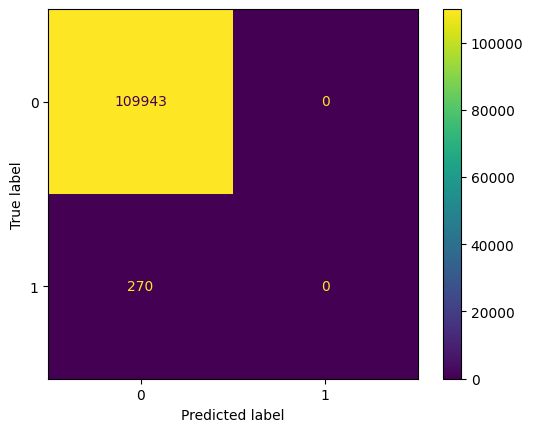

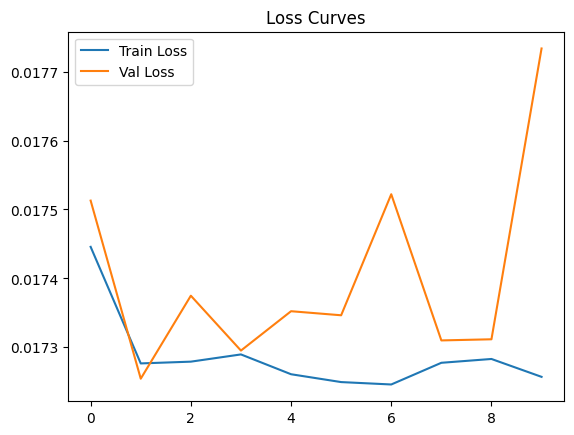


✅ Finished! Model and plots are ready.


In [14]:
# Lung Nodule Detection with Transformer (ViT-style)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Load Data
candidates_df = pd.read_csv("/kaggle/input/luna-lung-cancer-dataset/candidates.csv")
candidates_df['class'] = candidates_df['class'].astype(int)  # Ensure labels are int
print(candidates_df.head())

# 2. Define Dataset
class LunaCandidatesDataset(data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Fake patch extraction (normally you extract real CT patch)
        patch = np.random.randn(1, 32, 32, 32)  # simulate 3D patch for now
        label = row['class']
        patch = torch.tensor(patch, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return patch, label

# 3. Split Dataset
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(candidates_df, test_size=0.2, random_state=42, stratify=candidates_df['class'])

train_dataset = LunaCandidatesDataset(train_df)
val_dataset = LunaCandidatesDataset(val_df)

train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# 4. Define Transformer Model
class SimpleViT(nn.Module):
    def __init__(self, input_dim=32*32*32, num_classes=2, embed_dim=128, depth=6, heads=8):
        super(SimpleViT, self).__init__()
        self.flatten = nn.Flatten()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.embedding(x)
        x = x.unsqueeze(1)  # (batch, seq_len=1, embed_dim)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.classifier(x)
        return x

# 5. Train and Evaluate

def train(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


def evaluate(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return acc

# 6. Main Training Loop

model = SimpleViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 1e-4

train_losses, val_losses = train(model, train_loader, val_loader, num_epochs, learning_rate, device)
acc = evaluate(model, val_loader, device)

# 7. Plot Train and Val Loss Curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

# 8. Save Model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/luna_transformer.pth")

print("\n✅ Finished! Model and plots are ready.")
